# How You Can Avoid Car Accident in 2020
see post on medium.com:
https://medium.com/@RonghuiZhou/how-you-can-avoid-car-accident-in-2020-c9626c9b6f68


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on Montgomery County in the State of Pennsylvania. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

### Data source
https://www.kaggle.com/sobhanmoosavi/us-accidents


### Acknowledgements

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.

Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.


####  Author
Ronghui Zhou, zhou.uf@gmail.com
https://github.com/RonghuiZhou

In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Step 1. Import libraries

In [78]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import dependencies
import os
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
# from config import username, password
import time
from pathlib import Path
import pickle
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble.forest import RandomForestClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
import seaborn as sns


from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

### Step 2. Import the dataset

In [79]:
# Import the data
df = pd.read_csv('../resources/US_Accidents_June20.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [80]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               int64         
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

### Step 4. Deal with outliers

#### A. Drop rows with negative time_duration

In [81]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: Time_Duration(min), dtype: float64

In [82]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [83]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

### Step 4. Deal with outliers

#### B. Fill outliers with median values

In [84]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   TMC                    float64       
 3   Severity               float64       
 4   Start_Time             datetime64[ns]
 5   End_Time               datetime64[ns]
 6   Start_Lat              float64       
 7   Start_Lng              float64       
 8   End_Lat                float64       
 9   End_Lng                float64       
 10  Distance(mi)           float64       
 11  Description            object        
 12  Number                 float64       
 13  Street                 object        
 14  Side                   object        
 15  City                   object        
 16  County                 object        
 17  State                  object        
 18  Zipcode               

In [85]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 10140.0 minutes or 169 hours or 7 days; Min to clear an accident td: 1.0 minutes.


In [86]:
# Export the data
# df.to_csv('./US_Accidents_May19_clean.csv',index=False)

### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [87]:
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,Time_Duration(min)
0,A-1,MapQuest,201.0,3.0,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Night,2016.0,Feb,8.0,5.0,Mon,314.0
1,A-2,MapQuest,201.0,2.0,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Night,Night,Day,2016.0,Feb,8.0,6.0,Mon,30.0
2,A-3,MapQuest,201.0,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Night,Night,Day,Day,2016.0,Feb,8.0,6.0,Mon,30.0
3,A-4,MapQuest,201.0,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Night,Day,Day,Day,2016.0,Feb,8.0,7.0,Mon,30.0
4,A-5,MapQuest,201.0,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Day,Day,Day,Day,2016.0,Feb,8.0,7.0,Mon,30.0


In [88]:
# Set the list of features to include in Machine Learning 
# 'Severity', 
# 'Start_Time', 
# 'City', 
# 'County', 
# 'State', 
# 'Zipcode', 
# 'Temperature(F)
# 'Visibility(mi)', 
# 'Precipitation(in)', 
# 'Amenity', 
# 'Bump', 
# 'Crossing', 
# 'Give_Way', 
# 'Junction', 
# 'No_Exit', 
# 'Railway', 
# 'Roundabout', 
# 'Station', 
# 'Stop', 
# 'Traffic_Calming', 
# 'Traffic_Signal', 
# 'Turning_Loop', 
# 'Month', 
# 'Hour', 
# 'Weekday' 
# ID



feature_lst=['ID', 'Severity', 'Start_Time', 'City', 'County', 'State', 'Zipcode', 'Temperature(F)', 'Visibility(mi)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Month', 'Hour', 'Weekday' ]

In [89]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 26 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ID                 object        
 1   Severity           float64       
 2   Start_Time         datetime64[ns]
 3   City               object        
 4   County             object        
 5   State              object        
 6   Zipcode            object        
 7   Temperature(F)     float64       
 8   Visibility(mi)     float64       
 9   Precipitation(in)  float64       
 10  Amenity            float64       
 11  Bump               float64       
 12  Crossing           float64       
 13  Give_Way           float64       
 14  Junction           float64       
 15  No_Exit            float64       
 16  Railway            float64       
 17  Roundabout         float64       
 18  Station            float64       
 19  Stop               float64       
 20  Traffic_Calming    float

In [90]:
# Export the data with selected features
# df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

KeyboardInterrupt: 

### Step 6. Drop rows with missing values

In [91]:
# Check missing values
df_sel.isnull().mean()

ID                   0.000194
Severity             0.000194
Start_Time           0.000194
City                 0.000225
County               0.000194
State                0.000194
Zipcode              0.000498
Temperature(F)       0.018894
Visibility(mi)       0.021775
Precipitation(in)    0.576642
Amenity              0.000194
Bump                 0.000194
Crossing             0.000194
Give_Way             0.000194
Junction             0.000194
No_Exit              0.000194
Railway              0.000194
Roundabout           0.000194
Station              0.000194
Stop                 0.000194
Traffic_Calming      0.000194
Traffic_Signal       0.000194
Turning_Loop         0.000194
Month                0.000194
Hour                 0.000194
Weekday              0.000194
dtype: float64

In [92]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(1472451, 26)

In [93]:
# Export the data with selected features
df_sel.to_csv('./US_Accidents_Features_Selected.csv',index=False)

### Step 7. Select the state of interest: CA; and County of interest: Los Angeles
   

Due to the limitation of personal laptop, the whole US dataset is too big to handle

In [94]:
# Import data if it was already exported based on previous work
# df_sel=pd.read_csv('./US_Accidents_May19_clean_sel_dropna.csv')

trydf = df_sel.copy()
trydf



,ID,Severity,Start_Time,City,County,State,Zipcode,Temperature(F),Visibility(mi),Precipitation(in),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Month,Hour,Weekday
0,A-1,3.0,2016-02-08 05:46:00,Dayton,Montgomery,OH,45424,36.9,10.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,5.0,Mon
1,A-2,2.0,2016-02-08 06:07:59,Reynoldsburg,Franklin,OH,43068-3402,37.9,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,6.0,Mon
5,A-6,3.0,2016-02-08 07:44:26,Westerville,Franklin,OH,43081,37.9,7.0,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,7.0,Mon
9,A-10,3.0,2016-02-08 08:10:04,Westerville,Franklin,OH,43081,37.4,3.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,8.0,Mon
11,A-12,3.0,2016-02-08 08:21:27,Reynoldsburg,Franklin,OH,43068,37.4,3.0,0.02,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Feb,8.0,Mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513612,A-3513776,2.0,2019-08-23 18:03:25,Riverside,Riverside,CA,92501,86.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,18.0,Fri
3513613,A-3513777,2.0,2019-08-23 19:11:30,San Diego,San Diego,CA,92108,70.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri
3513614,A-3513778,2.0,2019-08-23 19:00:21,Orange,Orange,CA,92866,73.0,10.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri
3513615,A-3513779,2.0,2019-08-23 19:00:21,Culver City,Los Angeles,CA,90230,71.0,10.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Aug,19.0,Fri


In [27]:
# Set state
state='CA'

# select the state of California
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 470000 entries, 728 to 2478817
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Source              470000 non-null  object 
 1   TMC                 470000 non-null  float64
 2   Severity            470000 non-null  float64
 3   Start_Lng           470000 non-null  float64
 4   Start_Lat           470000 non-null  float64
 5   Distance(mi)        470000 non-null  float64
 6   Side                470000 non-null  object 
 7   City                470000 non-null  object 
 8   County              470000 non-null  object 
 9   Zipcode             470000 non-null  object 
 10  Timezone            470000 non-null  object 
 11  Temperature(F)      470000 non-null  float64
 12  Humidity(%)         470000 non-null  float64
 13  Pressure(in)        470000 non-null  float64
 14  Visibility(mi)      470000 non-null  float64
 15  Wind_Direction      470000 non-

In [95]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=trydf, hue='State', legend=False, s=20)
plt.show()

ValueError: Could not interpret input 'Start_Lng'

In [29]:
# Set county
# county='Los Angeles'

# # Select the county of LA 
# df_county=df_state.loc[df_state.County==county].copy()
# df_county.drop('County',axis=1, inplace=True)
# df_county.info()

#selecting zipcode 90022 for testing purposes
zc='90022'

# Select the county of LA 
df_county=df_state.loc[df_state.Zipcode==zc].copy()
df_county.drop('Zipcode',axis=1, inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 42963 to 2476003
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              1294 non-null   object 
 1   TMC                 1294 non-null   float64
 2   Severity            1294 non-null   float64
 3   Start_Lng           1294 non-null   float64
 4   Start_Lat           1294 non-null   float64
 5   Distance(mi)        1294 non-null   float64
 6   Side                1294 non-null   object 
 7   City                1294 non-null   object 
 8   County              1294 non-null   object 
 9   Timezone            1294 non-null   object 
 10  Temperature(F)      1294 non-null   float64
 11  Humidity(%)         1294 non-null   float64
 12  Pressure(in)        1294 non-null   float64
 13  Visibility(mi)      1294 non-null   float64
 14  Wind_Direction      1294 non-null   object 
 15  Weather_Condition   1294 non-null   object 
 16 

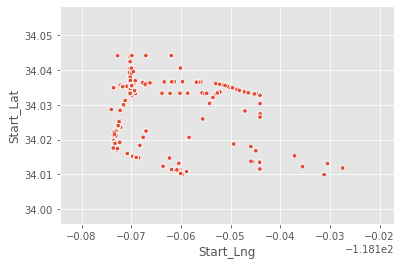

In [30]:
# Map of accidents, color code by city

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_county, hue='City', legend=False, s=20)
plt.show()

### Step 8. Deal with categorical data: pd.get_dummies()


# Generate dummies for categorical data
df_county_dummy = pd.get_dummies(df_county,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_county_dummy.info()

### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [101]:
trydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472451 entries, 0 to 3513616
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   ID                 1472451 non-null  object        
 1   Severity           1472451 non-null  float64       
 2   Start_Time         1472451 non-null  datetime64[ns]
 3   City               1472451 non-null  object        
 4   County             1472451 non-null  object        
 5   State              1472451 non-null  object        
 6   Zipcode            1472451 non-null  object        
 7   Temperature(F)     1472451 non-null  float64       
 8   Visibility(mi)     1472451 non-null  float64       
 9   Precipitation(in)  1472451 non-null  float64       
 10  Amenity            1472451 non-null  bool          
 11  Bump               1472451 non-null  bool          
 12  Crossing           1472451 non-null  bool          
 13  Give_Way           1472451 

In [97]:
trydf.dtypes

ID                           object
Severity                    float64
Start_Time           datetime64[ns]
City                         object
County                       object
State                        object
Zipcode                      object
Temperature(F)              float64
Visibility(mi)              float64
Precipitation(in)           float64
Amenity                     float64
Bump                        float64
Crossing                    float64
Give_Way                    float64
Junction                    float64
No_Exit                     float64
Railway                     float64
Roundabout                  float64
Station                     float64
Stop                        float64
Traffic_Calming             float64
Traffic_Signal              float64
Turning_Loop                float64
Month                        object
Hour                        float64
Weekday                      object
dtype: object

In [99]:
trydf = trydf.astype({
    'Amenity' : bool,
    'Bump' : bool,
    'Crossing' : bool,
    'Give_Way' : bool,
    'Junction' : bool,
    'No_Exit' : bool,
    'Railway' : bool,
    'Roundabout' : bool,
    'Station' : bool,
    'Stop' : bool,
    'Traffic_Calming' : bool,
    'Traffic_Signal' : bool,
    'Turning_Loop' : bool
})

trydf.dtypes

ID                           object
Severity                    float64
Start_Time           datetime64[ns]
City                         object
County                       object
State                        object
Zipcode                      object
Temperature(F)              float64
Visibility(mi)              float64
Precipitation(in)           float64
Amenity                        bool
Bump                           bool
Crossing                       bool
Give_Way                       bool
Junction                       bool
No_Exit                        bool
Railway                        bool
Roundabout                     bool
Station                        bool
Stop                           bool
Traffic_Calming                bool
Traffic_Signal                 bool
Turning_Loop                   bool
Month                        object
Hour                        float64
Weekday                      object
dtype: object

In [103]:
# Generate dummies for categorical data
dum9_df = pd.get_dummies(trydf,drop_first=True)

# Export data
# df_county_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

dum9_df.info()

MemoryError: Unable to allocate 1.97 TiB for an array with shape (1472451, 1472451) and data type uint8

In [35]:
for row in dum9_df.columns.to_list():
    print(row)

TMC
Severity
Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Visibility(mi)
Amenity
Bump
Crossing
Give_Way
Junction
No_Exit
Railway
Roundabout
Station
Stop
Traffic_Calming
Traffic_Signal
Turning_Loop
Hour
Time_Duration(min)
Source_MapQuest-Bing
Side_R
Wind_Direction_Calm
Wind_Direction_E
Wind_Direction_ENE
Wind_Direction_ESE
Wind_Direction_East
Wind_Direction_N
Wind_Direction_NE
Wind_Direction_NNE
Wind_Direction_NNW
Wind_Direction_NW
Wind_Direction_North
Wind_Direction_S
Wind_Direction_SE
Wind_Direction_SSE
Wind_Direction_VAR
Wind_Direction_Variable
Wind_Direction_W
Wind_Direction_WNW
Wind_Direction_WSW
Wind_Direction_West
Weather_Condition_Cloudy
Weather_Condition_Fair
Weather_Condition_Haze
Weather_Condition_Heavy Rain
Weather_Condition_Light Rain
Weather_Condition_Mostly Cloudy
Weather_Condition_Overcast
Weather_Condition_Partly Cloudy
Weather_Condition_Rain
Weather_Condition_Scattered Clouds
Sunrise_Sunset_Night
Weekday_Mon
Weekday_Sat
Weekday_Sun
Weekday_T

In [41]:
dum9_df.head()

,TMC,Severity,Start_Lng,Start_Lat,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Hour,Time_Duration(min),Source_MapQuest-Bing,Side_R,Wind_Direction_Calm,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Weather_Condition_Cloudy,Weather_Condition_Fair,Weather_Condition_Haze,Weather_Condition_Heavy Rain,Weather_Condition_Light Rain,Weather_Condition_Mostly Cloudy,Weather_Condition_Overcast,Weather_Condition_Partly Cloudy,Weather_Condition_Rain,Weather_Condition_Scattered Clouds,Sunrise_Sunset_Night,Weekday_Mon,Weekday_Sat,Weekday_Sun,Weekday_Thu,Weekday_Tue,Weekday_Wed
42963,201.0,2.0,-118.167702,34.036362,0.0,84.0,47.0,29.94,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,13.0,45.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
43027,201.0,2.0,-118.167046,34.044228,0.0,84.0,43.0,29.91,10.0,False,False,False,False,False,False,False,False,False,False,False,True,False,17.0,45.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
43386,201.0,3.0,-118.169891,34.035534,0.0,75.9,60.0,29.90,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,17.0,60.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
43414,201.0,2.0,-118.145157,34.033134,0.0,68.0,78.0,29.91,10.0,False,False,False,False,True,False,False,False,False,False,False,False,False,19.0,60.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
43637,201.0,3.0,-118.163589,34.012329,0.0,77.0,58.0,29.92,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,14.0,60.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [50]:
# Assign the data
df=dum9_df

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78, train_size=0.80)

In [52]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1035, 62)
(259, 62)
(1035,)
(259,)


In [53]:
# Creating a StandardScaler instance.
scaler = StandardScaler()

# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [55]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [56]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.695.


D:\AnacondaJupyter\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [61]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=58)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.583.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.583.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

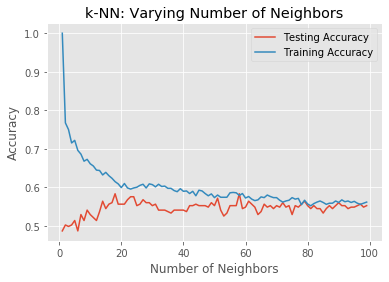

In [62]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 100)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [66]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.811.
[Decision Tree -- gini] accuracy_score: 0.834.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=500                

In [67]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

No handles with labels found to put in legend.


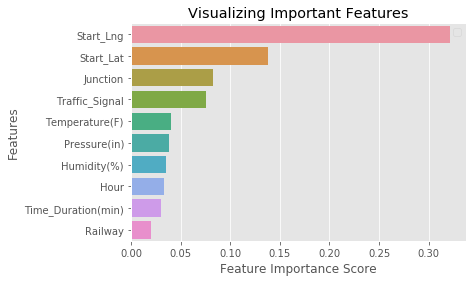

In [68]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [69]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lng                     0.321360
Start_Lat                     0.137924
Junction                      0.082347
Traffic_Signal                0.076004
Temperature(F)                0.039920
Pressure(in)                  0.038783
Humidity(%)                   0.035073
Hour                          0.033612
Time_Duration(min)            0.030684
Railway                       0.020586
Distance(mi)                  0.017969
Visibility(mi)                0.013670
Source_MapQuest-Bing          0.011368
TMC                           0.010661
Crossing                      0.008891
Station                       0.008340
Wind_Direction_Calm           0.007604
Sunrise_Sunset_Night          0.007084
Weekday_Wed                   0.007005
Weather_Condition_Overcast    0.006419
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [70]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500
building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


In [71]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=500, random_state=78, verbose=3, max_depth = 10)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500
building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestClassifier(max_depth=10, n_estimators=500, random_state=78,
                       verbose=3)

In [72]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.849.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.865.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

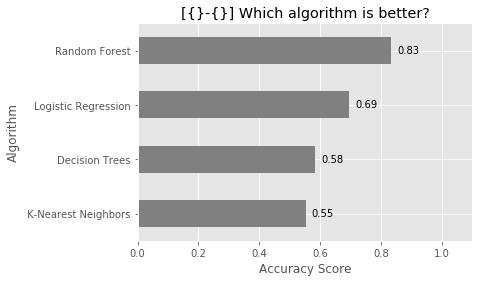

In [76]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}-{}] Which algorithm is better?')

plt.show()